# Predicting richness

Aim is to predict the bird richness of a sound file, given as input the ground-truth bird call detections in the file


In [141]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os
import sys
import collections
import numpy as np
import scipy.io.wavfile

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import frequency
from engaged.features import wave
from engaged.features import features as engaged_features
import cPickle as pickle
where_to_save = '/home/michael/projects/engaged_hackathon_data/detection/training_data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading richness values and plotting how many of each there are in dataset

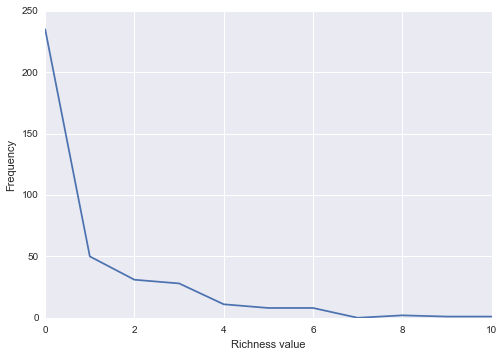

In [18]:
base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files/'
richness_csv = csv.reader(open(base_path + 'allSpeciesRichness.csv'))

# create dictionary mapping the name of a file to the integer richness value
filename_to_richness = {}
for count, filedata in enumerate(richness_csv):
    if count==0: continue
    filename_to_richness[filedata[0]] = int(filedata[1])
    
plt.plot(np.bincount(filename_to_richness.values()))
plt.xlabel('Richness value')
plt.ylabel('Frequency')

In [19]:
# load in the annotations
base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files/'
dataset_csv = csv.reader(open(base_path + 'urban_sounds_labels.csv'))

annotations = []  # list of all class info

def try_number(s):
    """Converts s to float if possible, else leaves as is"""
    try:
        return float(s)
    except ValueError:
        return s

# I'm basically reinventing pandas here - very silly
for count, line in enumerate(dataset_csv):
    if count == 0:
        header = line
        continue
        
    annotation = {label:try_number(item) for label, item in zip(header, line)}    
    annotation['length'] = \
        annotation['LabelEndTime_Seconds'] - annotation['LabelStartTime_Seconds']
    annotation['Label'] = annotation['Label'].strip().lower()
    annotations.append(annotation)

In [20]:
# group annotations by filename
file_annotations = collections.defaultdict(list)
for annotation in annotations:
    file_annotations[annotation['Filename']].append(annotation)

# Bird call count vs richness value
Here we look for relationship between the total number of bird sounds and the richness value

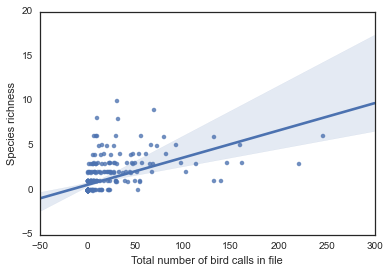

In [253]:
# get the count of how many birdcalls are in each file
filename_to_birdcallnumber = {}
for filename, annots in file_annotations.iteritems():
    count = len([xx for xx in annots if xx['Label'] == 'bird'])
    filename_to_birdcallnumber[filename] = count
    
filenames = filename_to_birdcallnumber.keys()

# get data ready for plotting...
X = np.array([filename_to_birdcallnumber[filename] for filename in filenames]).astype(float)
Y = np.array([filename_to_richness[filename] for filename in filenames]).astype(float)

# do the plot
sns.regplot(X, Y, y_jitter=.05, ci=100);
plt.xlabel('Total number of bird calls in file')
plt.ylabel('Species richness');

As expected there is a kind of relationship going on here, but it isn't really going to cut the mustard for the purposes of prediction/

## Load in bird call spectrograms
For each file, form a list of all the bird call spectrograms contained within

In [268]:
spectrogram_parameters = {
    'nfft': 1024,
    'window_width': 0.03,
    'overlap': 0.01
}

all_strips = collections.defaultdict(list)

for fname in filenames:
    
    # load file and convert to spectrogram
    sr, wav = scipy.io.wavfile.read(base_path + '25_Random/' + fname)  
    spec, spec_sr = frequency.spectrogram(wav, sr, **spectrogram_parameters)
    spec -= np.median(spec, axis=1)[:, None]
    
    # loop over each annotation...
    for annot in file_annotations[fname]:
        
        # just doing the birds
        if annot['Label'] == 'bird':
            
            # extract this section of the spectrogram and save
            start_time = annot['LabelStartTime_Seconds'] * spec_sr
            end_time =  annot['LabelEndTime_Seconds'] * spec_sr
            this_spec_segment = spec[:, start_time:end_time]
                        
            all_strips[fname].append(this_spec_segment)        

## Convert each bird call spectrogram to a canonical representation

Each bird call spectrogram is currently of a different length, so cannot be compared.
We therefore take the maximum, mean and variance across different strips of the spectrogram.


1 1 132 8 9 1 1 61 1 15 25 1 24 4 53 1 1 1 1 48 33 1 1 1 14 4 1 1 29 82 54 1 1 12 17 1 10 23 1 1 1 6 1 1 1 1 1 8 1 1 21 1 1 66 1 28 1 1 41 1 161 17 1 30 1 1 1 1 1 6 1 1 1 6 4 1 1 3 1 1 48 1 1 1 9 246 1 15 1 6 1 1 1 1 46 1 1 1 1 1 1 1 5 1 50 8 1 4 10 14 1 6 1 1 1 80 1 1 28 8 5 7 5 1 1 1 55 3 1 1 159 1 1 7 1 7 1 1 1 73 1 1 1 44 1 20 1 1 31 7 1 1 10 32 140 2 5 1 21 1 37 1 4 1 1 1 1 28 1 22 7 17 1 30 113 1 1 10 9 1 1 1 1 1 40 1 1 1 1 1 1 98 1 1 1 1 15 1 1 4 92 1 1 13 6 1 1 1 1 1 55 1 1 1 4 42 1 1 1 28 1 1 8 15 1 1 9 1 1 1 22 1 1 1 1 70 1 1 1 1 1 56 132 2 31 7 2 1 1 1 57 13 18 146 1 1 1 20 25 1 1 1 1 21 1 1 4 30 1 14 1 1 1 1 1 6 34 1 1 1 5 1 31 1 1 1 13 1 4 30 1 1 1 103 52 1 7 2 23 1 65 2 1 221 1 1 3 1 25 1 1 1 23 22 1 9 1 1 1 1 18 1 10 50 1 1 39 7 1 1 1 9 1 12 6 67 1 1 1 45 1 1 22 68 11 1 1 1 4 45 6 1 1 1 1 1 1 1 24 11 4 4


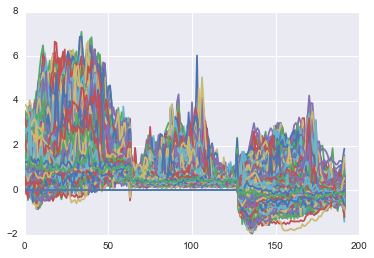

In [338]:
from skimage.util.shape import view_as_blocks


def frequency_max_pooling(spec):
    """
    Using code adapated from:
    http://scikit-image.org/docs/dev/auto_examples/plot_view_as_blocks.html
    """
    view = view_as_blocks(spec, (8, spec.shape[1]))
    flatten_view = view.reshape(view.shape[0], view.shape[1], -1)

    return np.hstack((np.max(flatten_view, axis=2).flatten(),
                      np.var(flatten_view, axis=2).flatten(),
                      np.mean(flatten_view, axis=2).flatten()))

variances = {}

for fname in filenames:
    
    if fname in all_strips:
        bird_specs = all_strips[fname]
    else:
        bird_specs = [np.zeros((512, 80))]

    strip_maxes = []

    for bird_spec in bird_specs:

        strip_maxes.append(frequency_max_pooling(bird_spec))

    print len(strip_maxes),
    
    if len(strip_maxes) > 0:
        XX = np.vstack(strip_maxes)
#         print XX.shape
        variances[fname] = XX.max(axis=0)
#     , ddof=1)
        variances[fname][np.isnan(variances[fname])] = 0
        plt.plot(XX.T)
#         print variances[fname].shape
    else:
        variances[fname] = np.zeros(512)

## Relationship between mean variance and richness

Here we look at all the bird calls in the file and take the variance across all the spectogram bins. Does the average of this variance tell us anything about the richness?

362
362
160


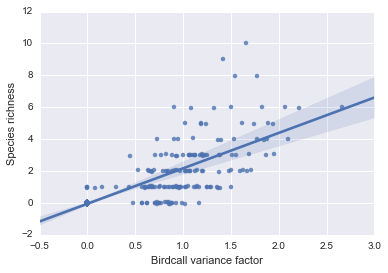

In [341]:
print len(variances.keys())
print len(filenames)
print len(all_strips)
# filenames = filename_to_birdcallnumber.keys()

X = np.array([variances[filename].mean() for filename in filenames]).astype(float)
Y = np.array([filename_to_richness[filename] for filename in filenames]).astype(float)

sns.regplot(X, Y, y_jitter=.05, ci=100);
plt.xlabel('Birdcall variance factor')
plt.ylabel('Species richness');

## Train/test splits to predict the richness

**Aim**: To predict the richness given just a detection of where all the bird calls are in a file.

**Method**: Using the variance along each channel of the frequency spectrum as features, train a random forest using a ground truth richness score. Do multiple train test splits. 


**Evaluation**: 

- *Mean absolute error*
- *Unbiased mean absolute error*: If *no* birds are detected, it is obvious that richness is zero. We therefore leave these files out of the evaluation for this metric
- *Fraction within one*: The fraction of the predictions which are within 1 of the ground truth

In [ ]:
# now lets try to use a forest to predict...
X = np.vstack([np.hstack((variances[filename], filename_to_birdcallnumber[filename]))
               for filename in filenames]).astype(float)
# X = np.array([filename_to_birdcallnumber[filename] for filename in filenames]).astype(float)[:, None]
print X.shape
print Y.shape

def split_train_test_eval(X, Y):
    # splits the data into train and test (possibly multiple splits),
    #     trains a model, tests the model and evaluates
    # also returns a single Y_test, Y_pred pair for plotting etc

    errors = []
    unbiased_errors = []
    test_pred_pairs = []
    
    n_trees = 10
    n_splits = 20
    
    for random_seed in range(100, 100+n_splits):
        X_train, X_test, Y_train, Y_test = \
            train_test_split(X, Y, random_state=random_seed, test_size=0.5)

        rf = RandomForestRegressor(n_trees, max_features=None, random_state=random_seed)
        rf.fit(X_train, Y_train)
        Y_pred = rf.predict(X_test)

        errors.append(mean_absolute_error(Y_test, Y_pred))
        unbiased_errors.append(
            mean_absolute_error(Y_test[Y_test>0], Y_pred[Y_test>0]))
        
        test_pred_pairs.append((Y_test, Y_pred))
        
        print "Split %d" % random_seed, 

    # 
    mean_error = np.array(errors).mean()
    mean_unbiased_error = np.array(unbiased_errors).mean()
    
    frac_within_one = \
        float(np.sum(np.abs(Y_pred - Y_test) < 1.0)) / Y_test.shape[0]
    
    # let's find the Y_test Y_pred pair which is closest to the mean unbiased error
    idx = np.argmin(np.abs(np.array(unbiased_errors) - mean_unbiased_error))
    return mean_error, mean_unbiased_error, frac_within_one, test_pred_pairs[idx], rf


def plot_predictions(Y_true, Y_pred):

    plt.figure(figsize=(10, 10))
    sns.set_style("darkgrid")
    # plt.plot(Y_test, Y_pred, '.')
    g = sns.regplot(Y_true[Y_true>0], Y_pred[Y_true>0], 
                    order=1, 
                    x_estimator=np.mean, 
                   label="t")
#     plt.plot(Y_true, Y_pred)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.axis('equal')

    x0, x1 = plt.gca().get_xlim()
    y0, y1 = plt.gca().get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    h2 = plt.plot(lims, lims, ':k', label='qq') 

(362, 193)
(362,)
Split 100 Split 101 Split 102 Split 103 Split 104 Split 105 Split 106 Split 107 Split 108 Split 109 Split 110 Split 111 Split 112 Split 113 Split 114 Split 115 Split 116 Split 117 Split 118 Split 119 
Mean absolute error:           0.564366598298
Ubiased mean absolute error:   1.20035938792
Fraction within 1:             0.762430939227


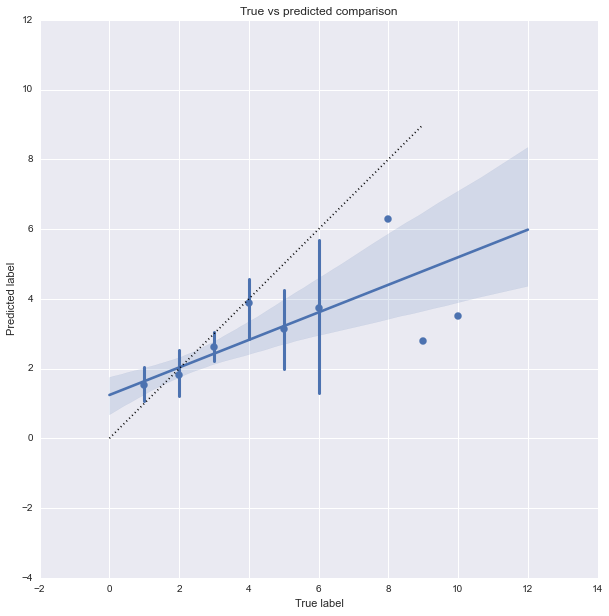

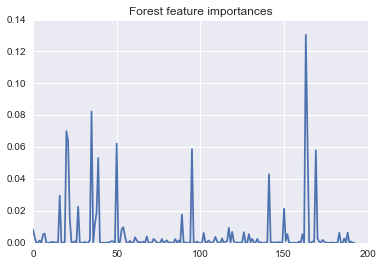

In [349]:
mae, unbias_mae, frac_within_one, (Y_test, Y_pred), rf = \
    split_train_test_eval(X, Y)

print ''
print "Mean absolute error:".ljust(30), mae
print "Ubiased mean absolute error:".ljust(30), unbias_mae
print "Fraction within 1:".ljust(30), frac_within_one
plot_predictions(Y_test, Y_pred)
plt.title("True vs predicted comparison")

plt.figure()
plt.plot(rf.feature_importances_)
plt.title('Forest feature importances')

# Conclusion

This method is pretty useless. Probably not much point for the time being... Alternatives:

- Classify the sounds using one of the sound datasets to get a more true richness score.
- Lots more training data like what we have
- Some kind of better feature representation, e.g. the clustered features like what Dan Stowell uses

One idea for investigating this work further is to write out an audio file of all the detected bird calls in a file, and see if an average human can give an accurate richness score! Would also be useful to get some insight into the algorithm...